# MoneyLion Loan Repayment Challenge

## Objective

We want to discern loan applicants' risk profiles and understand high risk and low risk applicants. This way we could minimise our losses. We would like to indentify applicants who are very much likely to repay their loans, and applicants who are likely to default on their loans.


### 1. Initial Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
%pip install ydata-profiling

In [2]:
loan_df = pd.read_csv('loan.csv', parse_dates=['applicationDate','originatedDate'])
payment_df = pd.read_csv('payment.csv', parse_dates=['paymentDate'])
clarity_df = pd.read_csv('clarity_underwriting_variables.csv')

C:\Users\jingy\AppData\Local\Temp\ipykernel_20380\2577149227.py:3: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  clarity_df = pd.read_csv('clarity_underwriting_variables.csv')


In [3]:
#Converting date columns to datetime format
loan_df[['applicationDate', 'originatedDate']] = loan_df[['applicationDate', 'originatedDate']].apply(pd.to_datetime, errors='coerce')
payment_df['paymentDate'] = pd.to_datetime(payment_df['paymentDate'], errors='coerce')

#Joining our 3 datasets together
merged_df_temp = pd.merge(loan_df, clarity_df, left_on="clarityFraudId", right_on="underwritingid", how="left")
merged_df = pd.merge(merged_df_temp, payment_df, left_on="loanId", right_on="loanId", how="left")

Using ydata_profiling's ProfileReport, to give us a quick understanding, and topline overview of our variables. The output is in this directory called "data.html".

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(merged_df, title='Data Description')
profile.to_notebook_iframe

In [ ]:
cwd = os.getcwd()
profile.to_file(cwd)

Key Takeaways:

1. **loanID**: There are 47.1% loans that are distinct, this suggests that a single csutomer could have multiple loans.
2. **payFrequency**: 51.2% of the people pay their loans Biweekly.
3. **apr**: I am not sure if these are credit scores, because these seem very high if their percentages, with a mean of 536%
4. **nPaidOff** - Most borrowers in this dataset have not paid off any previous MoneyLion loans
5. **isFunded** - There is about a 45.2% of loans which are not funded, and 54.8% loans which are funded
6. **loanAmount** - Vary widely, with loans clutered around $500 range. There are loans with zero amount, which could indicate data entry errors.
7. **isCollection** - A majority of the applicants are able to pay during the scheduled times, only a mere 1.1% have custom payment plans

In [4]:
merged_df['loanStatus'].value_counts(normalize=True)

loanStatus
Withdrawn Application          0.367704
External Collection            0.177097
Paid Off Loan                  0.153941
New Loan                       0.105316
Internal Collection            0.076707
Rejected                       0.069348
Returned Item                  0.014338
Settlement Paid Off            0.011515
Credit Return Void             0.009120
Customer Voided New Loan       0.004865
Settled Bankruptcy             0.004516
Pending Paid Off               0.002205
Charged Off Paid Off           0.002060
CSR Voided New Loan            0.001127
Pending Rescind                0.000068
Voided New Loan                0.000032
Charged Off                    0.000011
Settlement Pending Paid Off    0.000011
Customver Voided New Loan      0.000010
Pending Application Fee        0.000004
Pending Application            0.000003
Name: proportion, dtype: float64

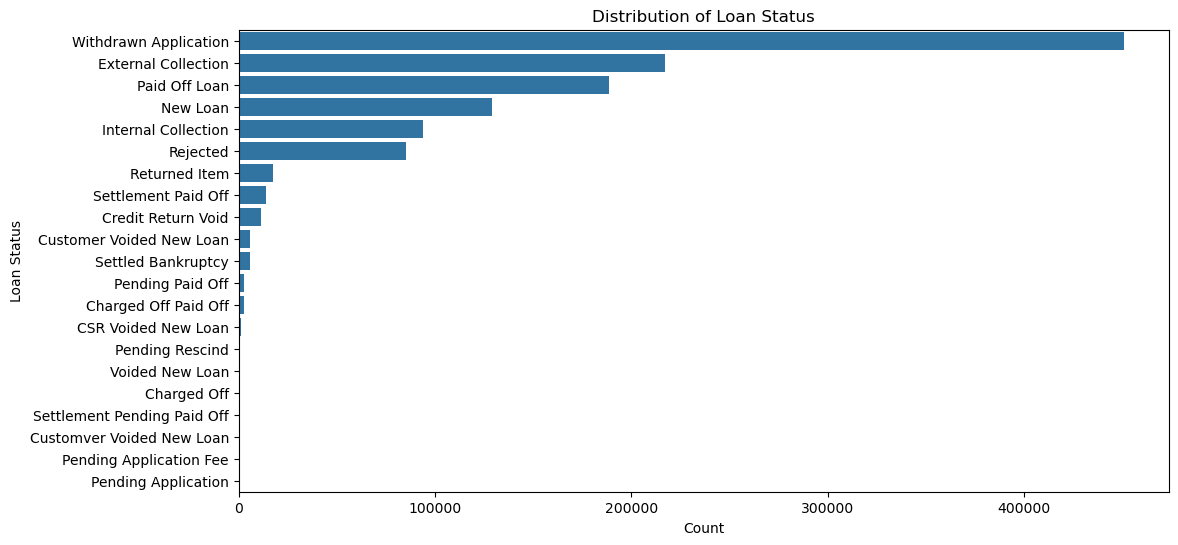

In [5]:
#Visualising the distribution of our loan status
plt.figure(figsize=(12,6))
sns.countplot(data=merged_df, y='loanStatus', order=merged_df['loanStatus'].value_counts().index)
plt.title('Distribution of Loan Status')
plt.xlabel('Count')
plt.ylabel('Loan Status')
plt.show()

There is a really high percentage of applicants that have withdrawn their application, this could be due to several reasons.
- Better financial alternative
- Change in financial circumstances
- Better Loan offers from other firms
- Frustrations in application process
- Market or Economic conditions

I believe this is where the 'isFunded == 0' applicants are from. With this, we shall only focus on loans that are funded for the sole purpose of our objective, where if I remove empty loan statuses, it will remove the people whose application has been withdrawn.

In [6]:
#Filtering for funded loans
merged_df = merged_df[merged_df['isFunded']==1]

We see here there are a bunch of values for Loan Status. However if we categorised these by risk profiles, it turns into a binary classification problem. Where the positive class are people that pay off their loan, and the negative class where people are most likely to default.

- **Positive class**: Paid Off Loan, Settlement Paid Off
- **Negative Class**: Settled Bankruptcy, Customer Voided New Loan, Charged Off

In [7]:
status_mapping = {
    "Paid Off Loan": 1,
    "Settlement Paid Off": 1,
    "Settled Bankruptcy": 0,
    "Customer Voided New Loan": 0,
    "Charged Off": 0
}

merged_df['class'] = merged_df['loanStatus'].map(status_mapping)
merged_df = merged_df.dropna(subset=['class'])

<Axes: xlabel='class'>

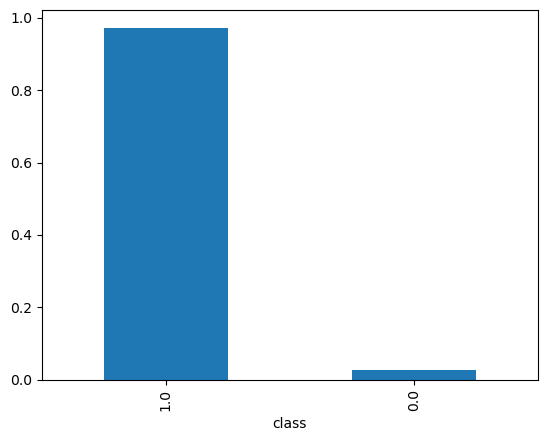

In [8]:
merged_df['class'].value_counts(normalize=True).plot(kind='bar', x='Class')

In [9]:
class_counts = merged_df['class'].value_counts(normalize=True)
print(class_counts)

#Calculate the ratio between the two classes
ratio = class_counts[0] / class_counts[1]  #Assuming 0 is the negative class and 1 is the positive class
print(f'Class imbalance ratio (0 to 1): {ratio:.2f}')

if ratio > 1.5 or ratio < 0.67:  # Checks if either class is more than 1.5 times the size of the other
    print("There is a significant class imbalance.")
else:
    print("The classes are balanced.")

class
1.0    0.973374
0.0    0.026626
Name: proportion, dtype: float64
Class imbalance ratio (0 to 1): 0.03
There is a significant class imbalance.


The current distribution of classes in the dataset shows a significant imbalance, with the positive class (1) having a higher number of instances compared to the negative class (0). This imbalance can potentially bias the model towards predicting the majority class, leading to poor performance in identifying the minority class. We will have to use the SMOTE method to oversample the negative class, this will ensure that our model can accurately predict classes without biases.

### 2. EDA

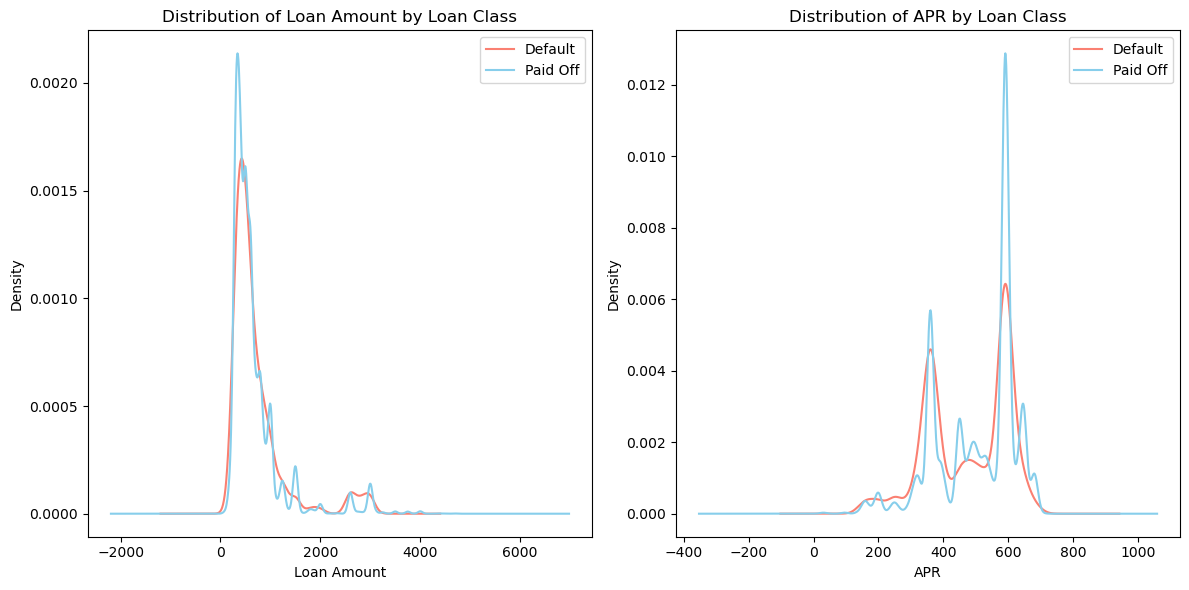

In [10]:
#Plotting the distribution of loan amounts by loan class
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
merged_df[merged_df['class'] == 0]['loanAmount'].plot(kind='kde', color='salmon', label='Default')
merged_df[merged_df['class'] == 1]['loanAmount'].plot(kind='kde', color='skyblue', label='Paid Off')
plt.title('Distribution of Loan Amount by Loan Class')
plt.xlabel('Loan Amount')
plt.legend()

plt.subplot(1, 2, 2)
merged_df[merged_df['class'] == 0]['apr'].plot(kind='kde', color='salmon', label='Default')
merged_df[merged_df['class'] == 1]['apr'].plot(kind='kde', color='skyblue', label='Paid Off')
plt.title('Distribution of APR by Loan Class')
plt.xlabel('APR')
plt.legend()

plt.tight_layout()
plt.show()


The distributions of loan amounts for defaulters and non-defaulters are quite similar, with a slight difference where non-defaulters seem to have a more pronounced peak around the lower loan amounts. This indicates that the loan amount alone might not be a strong predictor of default.

The APR distributions for defaulters and non-defaulters are similar, though non-defaulters have slightly higher density around lower APR values. Higher APRs could be associated with higher risk, but this doesn't seem to be a decisive factor alone.

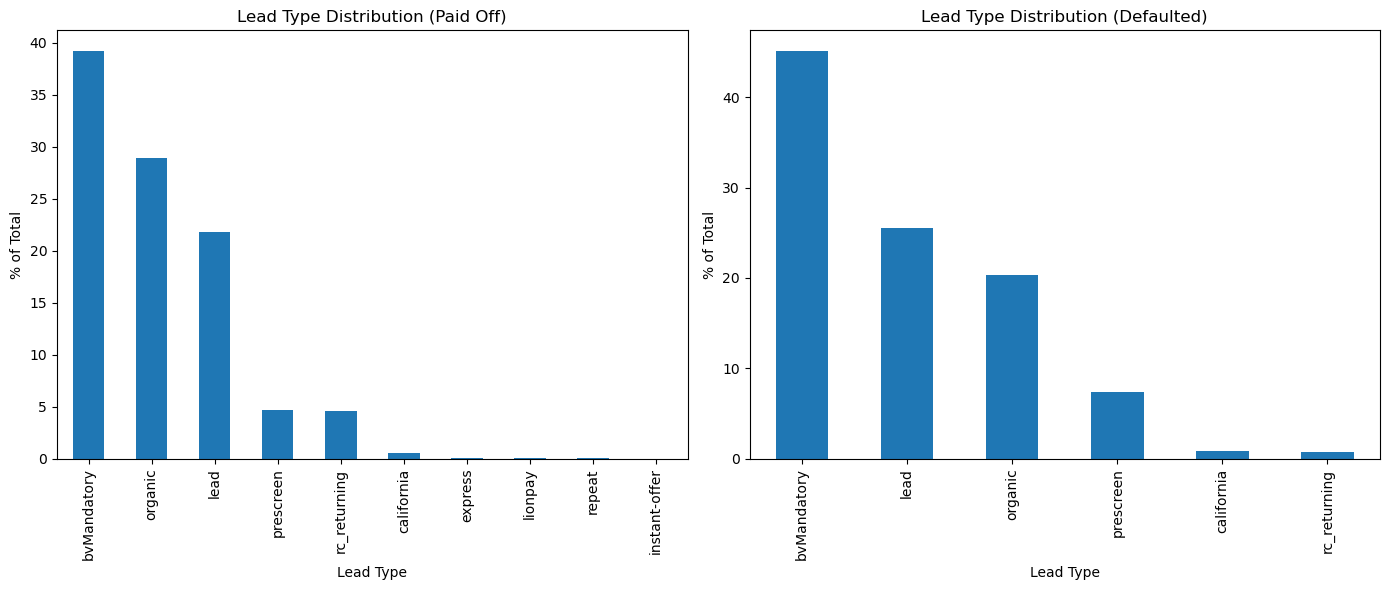

In [11]:
#Lead Type distribution by loan class
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
lead_type_counts = merged_df[merged_df['class'] == 1]['leadType'].value_counts(normalize=True) * 100
lead_type_counts.plot(kind='bar')
plt.title('Lead Type Distribution (Paid Off)')
plt.xlabel('Lead Type')
plt.ylabel('% of Total')

plt.subplot(1, 2, 2)
lead_type_counts_default = merged_df[merged_df['class'] == 0]['leadType'].value_counts(normalize=True) * 100
lead_type_counts_default.plot(kind='bar')
plt.title('Lead Type Distribution (Defaulted)')
plt.xlabel('Lead Type')
plt.ylabel('% of Total')

plt.tight_layout()
plt.show()


The bvMandatory lead type is the most common among paid-off loans, followed by organic and lead. This suggests that these lead types might be associated with better repayment behavior.

bvMandatory is still the most common lead type among defaulters, but lead and organic also appear significantly. The presence of lead as a strong second suggests that this lead type might have a higher risk associated with it.

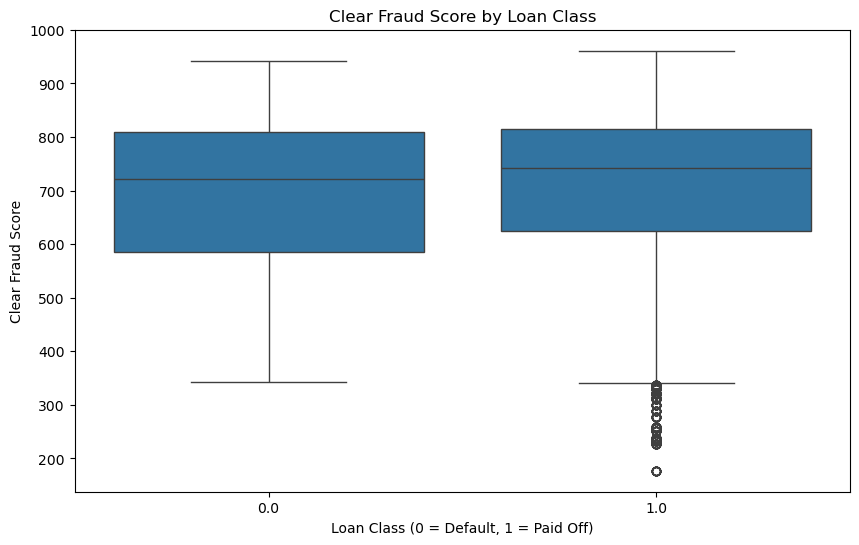

In [12]:
#Boxplot of clearfraudscore by loan class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='clearfraudscore', data=merged_df)
plt.title('Clear Fraud Score by Loan Class')
plt.xlabel('Loan Class (0 = Default, 1 = Paid Off)')
plt.ylabel('Clear Fraud Score')
plt.show()


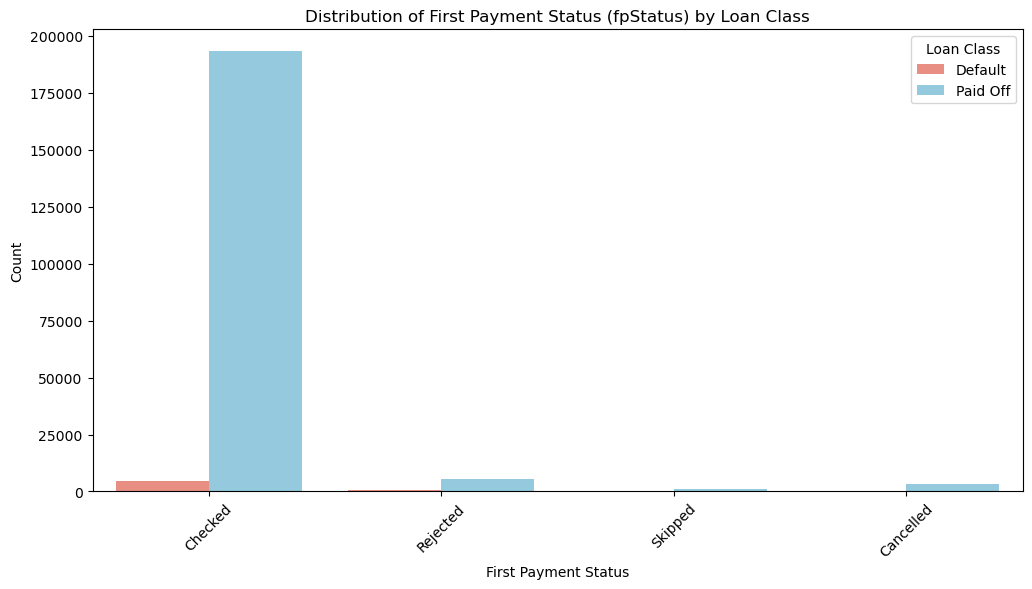

In [13]:
#Distribution of fpStatus by loan class
plt.figure(figsize=(12, 6))
sns.countplot(x='fpStatus', hue='class', data=merged_df, palette=['salmon', 'skyblue'])
plt.title('Distribution of First Payment Status (fpStatus) by Loan Class')
plt.xlabel('First Payment Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Loan Class', labels=['Default', 'Paid Off'])
plt.show()

A vast majority of non-defaulters had successful first payments. Very few defaulters had a successful first payment, indicating that the first payment is a critical predictor of loan performance.

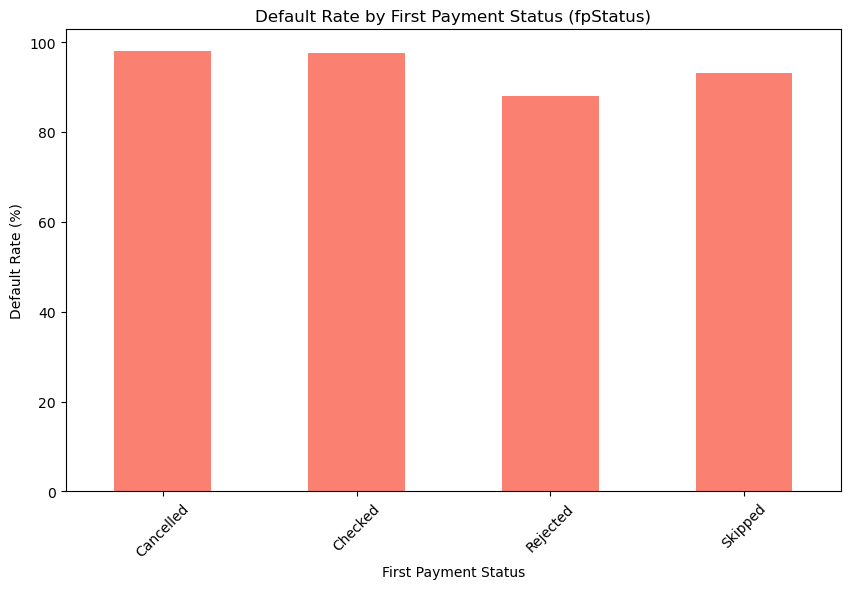

fpStatus
Cancelled    97.957881
Checked      97.654927
Rejected     88.011152
Skipped      93.231047
Name: class, dtype: float64


In [14]:
#Calculate the percentage of defaults for each fpStatus
fp_status_default_rate = merged_df.groupby('fpStatus')['class'].mean() * 100

#Plotting the default rates
plt.figure(figsize=(10, 6))
fp_status_default_rate.plot(kind='bar', color='salmon')
plt.title('Default Rate by First Payment Status (fpStatus)')
plt.xlabel('First Payment Status')
plt.ylabel('Default Rate (%)')
plt.xticks(rotation=45)
plt.show()

print(fp_status_default_rate)


The default rate is extremely high for loans with first payments that are Cancelled, Rejected, or Skipped. This strongly indicates that issues with the first payment are a major red flag for future defaults.

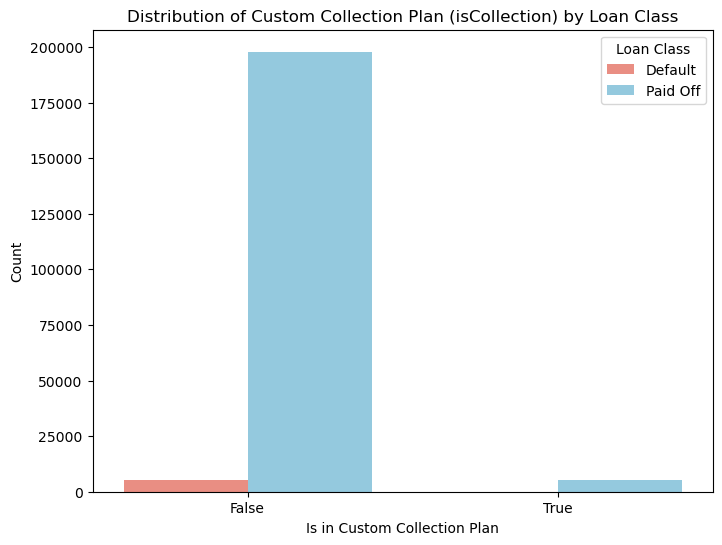

In [15]:
#Distribution of isCollection by loan class
plt.figure(figsize=(8, 6))
sns.countplot(x='isCollection', hue='class', data=merged_df, palette=['salmon', 'skyblue'])
plt.title('Distribution of Custom Collection Plan (isCollection) by Loan Class')
plt.xlabel('Is in Custom Collection Plan')
plt.ylabel('Count')
plt.legend(title='Loan Class', labels=['Default', 'Paid Off'])
plt.show()


Most of the loans that were paid off did not enter a custom collection plan. Loans that did enter a custom collection plan have a small presence in the non-default group but a significant presence in the default group. I believe that custom paid loans offer the flexibility for customers, allowing them to have a bigger breathing room.

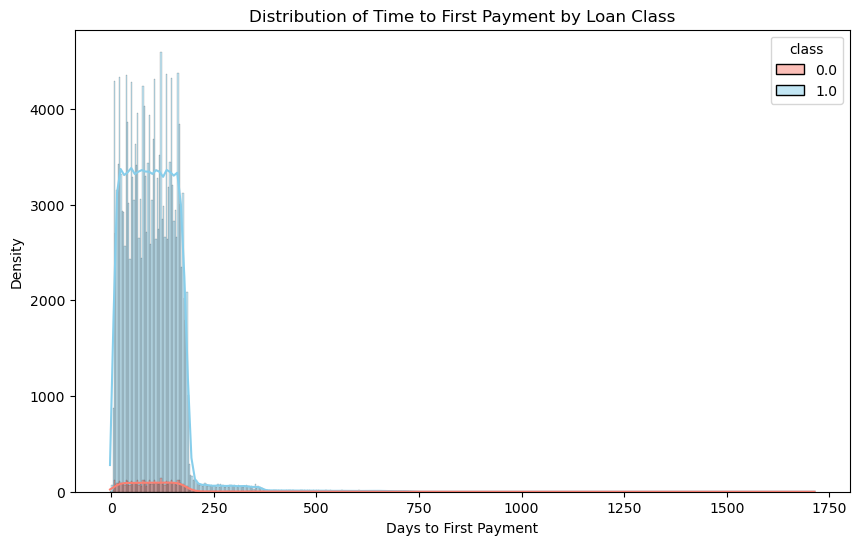

In [16]:
#Calculating the time of payment to it's originated day
merged_df['timeToFirstPayment'] = (merged_df['paymentDate'] - merged_df['originatedDate']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='timeToFirstPayment', hue='class', kde=True, palette=['salmon', 'skyblue'])
plt.title('Distribution of Time to First Payment by Loan Class')
plt.xlabel('Days to First Payment')
plt.ylabel('Density')
plt.show()

The majority of loans, for both classes have a very short time to their first payment, primarily clustered around the early days after the loan origination. Most borrowers begin repaying their loans relatively quickly after the loan is originated. Howevers, there is a noticeable difference in the density of defaulters and non-defaulters within the early time frame. There is a long tail extending towards higher values (up to 1750 days) for both classes, but it is more pronounced for non-defaulters.

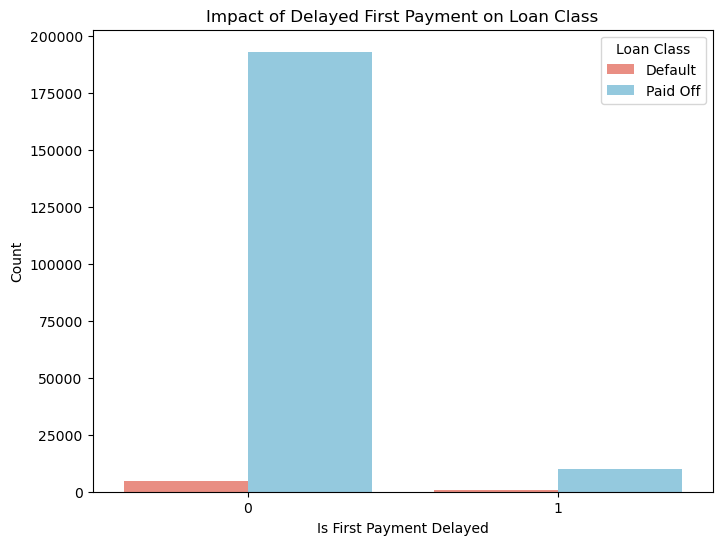

In [17]:
#Checking if a payment is Delayed from fpStatus, (0) if it is paid, (1) if a payment has not been paid
merged_df['isFirstPaymentDelayed'] = merged_df['fpStatus'].apply(lambda x: 0 if x == 'Checked' else 1)

plt.figure(figsize=(8, 6))
sns.countplot(x='isFirstPaymentDelayed', hue='class', data=merged_df, palette=['salmon', 'skyblue'])
plt.title('Impact of Delayed First Payment on Loan Class')
plt.xlabel('Is First Payment Delayed')
plt.ylabel('Count')
plt.legend(title='Loan Class', labels=['Default', 'Paid Off'])
plt.show()

We can see here that majority of people who are likely to pay off their loans, always make their first payments. However, more data is needed for the defaulters to see a difference.

### 3. Data Preprocessing

In [18]:
pd.set_option('display.max_rows', 4000)

In [19]:
#Dropping irrelevant columns for modelling
drop_columns = [
    'loanId', 
    'anon_ssn', 
    'applicationDate', 
    'originatedDate', 
    'approved', 
    'isFunded', 
    'state', 
    'fpStatus', 
    'clarityFraudId', 
    'hasCF', 
    'underwritingid',
    'paymentDate', 
    'paymentStatus', 
    'paymentReturnCode'
]

merged_df.drop(drop_columns,axis=1,inplace=True)


In [20]:
merged_df.replace({False: 0, True: 1}, inplace = True)

C:\Users\jingy\AppData\Local\Temp\ipykernel_20380\1876471460.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({False: 0, True: 1}, inplace = True)


In [21]:
missing_percentage = merged_df.isnull().sum().sort_values(ascending=False) * 100/len(merged_df)
missing_percentage

.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype                           97.233319
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription        95.867963
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode                   95.867963
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode               91.327326
.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription    91.327326
.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile            84.628591
.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode                    83.709722
.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone           39.856223
.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone    

In [22]:
threshold = int(0.8*merged_df.shape[1])
merged_df = merged_df.dropna(axis=0, thresh=threshold)
merged_df.head()

,payFrequency,apr,originated,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,leadType,leadCost,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,installmentIndex,isCollection,principal,fees,paymentAmount,class,timeToFirstPayment,isFirstPaymentDelayed
1,B,199.0,1,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,3.0,...,5.0,879.0,1.0,0.0,151.98,114.49,266.47,1.0,6.0,0
2,B,199.0,1,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,3.0,...,5.0,879.0,2.0,0.0,49.08,217.39,266.47,1.0,20.0,0
3,B,199.0,1,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,3.0,...,5.0,879.0,3.0,0.0,52.83,213.64,266.47,1.0,34.0,0
4,B,199.0,1,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,3.0,...,5.0,879.0,4.0,0.0,56.86,209.61,266.47,1.0,48.0,0
5,B,199.0,1,0.0,Paid Off Loan,3000.0,6395.19,prescreen,0,3.0,...,5.0,879.0,5.0,0.0,61.20,205.27,266.47,1.0,62.0,0


In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169421 entries, 1 to 1227074
Data columns (total 70 columns):
 #   Column                                                                                               Non-Null Count   Dtype  
---  ------                                                                                               --------------   -----  
 0   payFrequency                                                                                         169421 non-null  object 
 1   apr                                                                                                  169421 non-null  float64
 2   originated                                                                                           169421 non-null  int64  
 3   nPaidOff                                                                                             169409 non-null  float64
 4   loanStatus                                                                                           1

In [24]:
def extract_cols(df):
    """
    Takes in a dataframe and returns two lists
    Numerical Columns & Categorical Columns

    """
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    return numerical_cols, categorical_cols


numerical_cols, categorical_cols = extract_cols(merged_df)

print(len(numerical_cols) + len(categorical_cols))

70


#### Imputing Missing Values

In [25]:
def impute_na_values(df, numerical_cols, categorical_cols):
    
    #Imputing missing values of numerical columns with median
    num_imputer = SimpleImputer(strategy='median')
    df[numerical_cols] = num_imputer.fit_transform(df[numerical_cols])

    #Imputing missing values of categorical columns with 'Missing'
    cat_imputer = SimpleImputer(strategy='constant', fill_value='Missing')
    df[categorical_cols] = cat_imputer.fit_transform(df[categorical_cols])

    return df

merged_df = impute_na_values(merged_df, numerical_cols, categorical_cols)

In [26]:
merged_df.isna().sum().sum()

0

In [27]:
numerical_features = [col for col in numerical_cols if col != 'class']

#Using RobustScaler instead of MinMax & Standard scaler due to outliers
scaler = RobustScaler()
merged_df[numerical_features] = scaler.fit_transform(merged_df[numerical_features])

In [28]:
merged_df = pd.get_dummies(merged_df, columns=categorical_cols)

In [29]:
merged_df.replace({False: 0, True: 1}, inplace=True)

C:\Users\jingy\AppData\Local\Temp\ipykernel_20380\1581824399.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace({False: 0, True: 1}, inplace=True)


In [30]:
merged_df.head()

,apr,originated,nPaidOff,loanAmount,originallyScheduledPaymentAmount,leadCost,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode_Missing,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode_S03,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode_S07,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode_A8,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode_Missing,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch_invalid,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch_match,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch_mismatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch_partial,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch_unavailable
1,-1.7,0.0,0.0,6.25,4.777493,-0.6,-0.333333,-0.5,0.5,0.0,...,1,0,0,0,1,1,0,0,0,0
2,-1.7,0.0,0.0,6.25,4.777493,-0.6,-0.333333,-0.5,0.5,0.0,...,1,0,0,0,1,1,0,0,0,0
3,-1.7,0.0,0.0,6.25,4.777493,-0.6,-0.333333,-0.5,0.5,0.0,...,1,0,0,0,1,1,0,0,0,0
4,-1.7,0.0,0.0,6.25,4.777493,-0.6,-0.333333,-0.5,0.5,0.0,...,1,0,0,0,1,1,0,0,0,0
5,-1.7,0.0,0.0,6.25,4.777493,-0.6,-0.333333,-0.5,0.5,0.0,...,1,0,0,0,1,1,0,0,0,0


### 4. Model Building

To address the issue of class imbalance, we use the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples for the minority class, ensuring a more balanced distribution in the training data.

We use Stratified k-fold here to ensure that each fold in our cross validation process has the same proportion of classes as the original dataset. This is particularly useful in our case of imbalanced dataset

We use F1 Score as our main performance metric.

In [31]:
smote = SMOTE(random_state=42)

In [32]:
X = merged_df.loc[:, ~merged_df.columns.isin(['class'])]
y = merged_df[['class']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [35]:
#Checking results after applying SMOTE 
y_train_resampled.value_counts()

class
0.0      131669
1.0      131669
Name: count, dtype: int64

In [36]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10, 15]},
    'XGBoost': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3]}
}

In [37]:
#Confusion matrix plot function
def conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()


Training Logistic Regression...


c:\Users\jingy\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters: {'C': 1}
F1 score: 1.0000


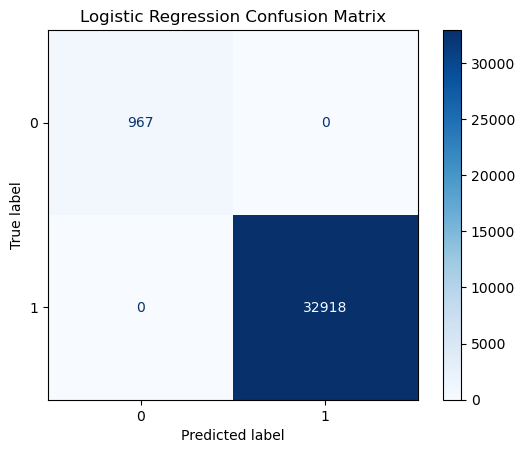


Training Random Forest...


c:\Users\jingy\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters: {'max_depth': None, 'n_estimators': 100}
F1 score: 1.0000


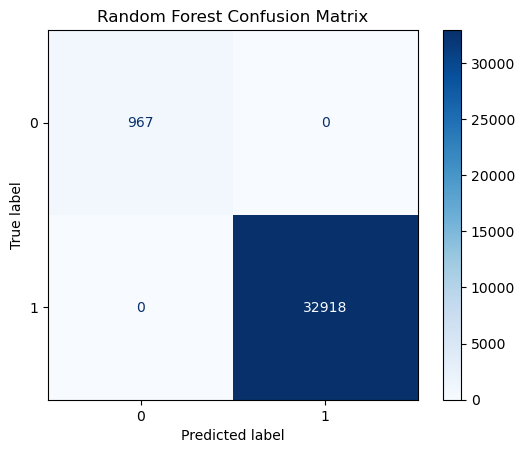


Training XGBoost...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
F1 score: 1.0000


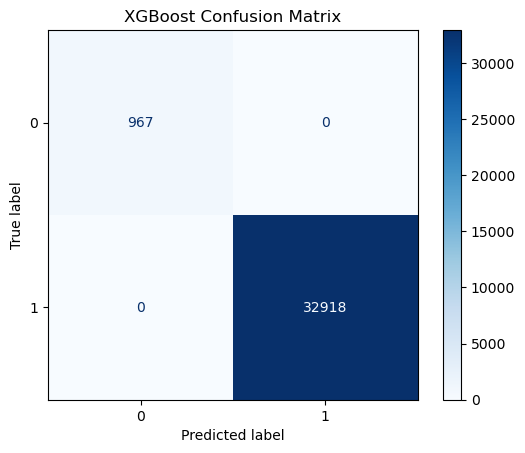

In [38]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    #GridSearchCV with stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='f1', n_jobs=-1)
    
    #Fit the model
    grid_search.fit(X_train_resampled, y_train_resampled)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    
    f1 = f1_score(y_test, y_pred)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"F1 score: {f1:.4f}")
    
    #Plot confusion matrix
    conf_matrix(y_test, y_pred, f"{name} Confusion Matrix")

- True Negative (Top-Left Quadrant)
- False Positive (Top-Right Quadrant)
- False Negative (Bottom-Left Quadrant)
- True Positive (Bottom-Right Quadrant)

### 5. Summary

From the results, it looks like our models performed perfectly, with no false positives or false negatives. There could be potential signs of overfitting, further evaluation on a separate validation set that varies widely from our training data is needed. I doubt that the model should be able to generalise itself on real world data. Moreover, I believe more sophisticated data preprocessing has to be done to avoid data leakage. Lastly, more data regards to people defaulting is needed for our model to work in a real-world, maybe include data like occupation, education level, credit scores etc.